# DDPG-EMS

In [1]:
# -*- coding: utf-8 -*-
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import tensorflow.compat.v1 as tf
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
from Priority_Replay import Memory
np.random.seed(1)
tf.set_random_seed(1)
tf.reset_default_graph()   # Python的控制台会保存上次运行结束的变量

## 超参数

In [2]:
from EREV_model import EREV
MAX_EPISODES = 5            # 500 运行次数
LR_A = 0.001                # 演员学习率
LR_C = 0.001                # 批评家学习率
GAMMA = 0.9                 # 奖励折扣
TAU = 0.01                  # soft replacement
MEMORY_CAPACITY = 10000     # 记忆容量
BATCH_SIZE = 64             # 一次训练所抓取的数据样本数量
RENDER = False

## DDPG算法

In [14]:
class DDPG(object):
    def __init__(self, a_dim, s_dim, a_bound,):
        self.memory = Memory(capacity = MEMORY_CAPACITY)
        self.pointer = 0
        self.sess = tf.Session()
        # 动作，状态，
        self.a_dim, self.s_dim, self.a_bound = a_dim, s_dim, a_bound,
        # tf.placeholder：在神经网络构建graph的时候在模型中的占位，此时并没有把要输入的数据传入模型，它只会分配必要的内存。
        # 等建立session，在会话中，运行模型的时候通过feed_dict()函数向占位符喂入数据。
        self.S = tf.placeholder(tf.float32, [None, s_dim], 's')
        self.S_ = tf.placeholder(tf.float32, [None, s_dim], 's_')
        self.R = tf.placeholder(tf.float32, [None, 1], 'r')
        self.ISWeights = tf.placeholder(tf.float32, [None, 1], 'ISWeights')
        # assign self.a = a in memory when calculating q for td_error,otherwise the self.a is from Actor when updating Actor
        # 当为td_error计算q时，在内存中分配self.a = a，否则当更新Actor时self.a来自于Actor
        with tf.variable_scope('Actor'):# tf.variable_scope：用于定义创建变量(层)的操作的上下文管理器
            self.a = self._build_a(self.S, scope='eval', trainable=True)
            a_ = self._build_a(self.S_, scope='target', trainable=False)
        with tf.variable_scope('Critic'):
            q = self._build_c(self.S, self.a, scope='eval', trainable=True)
            q_ = self._build_c(self.S_, a_, scope='target', trainable=False)

        # 网络参数
        self.ae_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/eval')
        self.at_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Actor/target')
        self.ce_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/eval')
        self.ct_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Critic/target')

        # 目标网络替代
        self.soft_replace = [[tf.assign(ta, (1 - TAU) * ta + TAU * ea), tf.assign(tc, (1 - TAU) * tc + TAU * ec)]
                             for ta, ea, tc, ec in zip(self.at_params, self.ae_params, self.ct_params, self.ce_params)]

        q_target = self.R + GAMMA * q_
        # in the feed_dic for the td_error, the self.a should change to actions in memory
        td_error = tf.losses.mean_squared_error(labels=q_target, predictions=q)
        self.td_error_up = abs(q_target - q) * self.ISWeights 
        self.ctrain = tf.train.AdamOptimizer(LR_C).minimize(td_error * self.ISWeights, var_list=self.ce_params)

        a_loss = tf.reduce_mean(q)    # maximize the q
        self.atrain = tf.train.AdamOptimizer(LR_A).minimize(a_loss, var_list=self.ae_params)
        
        self.sess.run(tf.global_variables_initializer())

    def choose_action(self, s):
        return self.sess.run(self.a, {self.S: s[np.newaxis, :]})[0]

    def learn(self):
        # soft target replacement
        self.sess.run(self.soft_replace)

#        indices = np.random.choice(MEMORY_CAPACITY, size=BATCH_SIZE)
#        bt = self.memory[indices, :]
        tree_index, bt, ISWeights = self.memory.sample(BATCH_SIZE)
        bs = bt[:, :self.s_dim]
        ba = bt[:, self.s_dim: self.s_dim + self.a_dim]
        br = bt[:, -self.s_dim - 1: -self.s_dim]
        bs_ = bt[:, -self.s_dim:]
        
        self.sess.run(self.atrain, {self.S: bs})
        self.sess.run(self.ctrain, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_, self.ISWeights: ISWeights})       
        abs_td_error = self.sess.run(self.td_error_up, {self.S: bs, self.a: ba, self.R: br, self.S_: bs_, self.ISWeights: ISWeights})        
        self.memory.batch_update(tree_index, abs_td_error)

    def store_transition(self, s, a, r, s_):
        transition = np.hstack((s, a, r, s_))
#        index = self.pointer % MEMORY_CAPACITY  # replace the old memory with new memory
#        self.memory[index, :] = transition
        self.memory.store(transition)
        self.pointer += 1

    def _build_a(self, s, scope, trainable):
        with tf.variable_scope(scope):
            net1 = tf.layers.dense(s, 200, activation=tf.nn.relu, name='l1', trainable=trainable)
            net2 = tf.layers.dense(net1, 100, activation=tf.nn.relu, name = 'l2', trainable=trainable)
            net3 = tf.layers.dense(net2, 50, activation=tf.nn.relu, name = 'l3', trainable=trainable)
            a = tf.layers.dense(net3, self.a_dim, activation=tf.nn.sigmoid, name='a', trainable=trainable)
            return tf.multiply(a, self.a_bound, name='scaled_a')

    def _build_c(self, s, a, scope, trainable):
        with tf.variable_scope(scope):
            n_l1 = 200
            n_l2 = 100
            n_l3 = 50
            w1_s = tf.get_variable('w1_s', [self.s_dim, n_l1], trainable=trainable)
            w1_a = tf.get_variable('w1_a', [self.a_dim, n_l1], trainable=trainable)
            b1 = tf.get_variable('b1', [1, n_l1], trainable=trainable)
            w2 = tf.get_variable('w2', [n_l1, n_l2], trainable=trainable)
            b2 = tf.get_variable('b2', [1, n_l2], trainable=trainable)
            w3 = tf.get_variable('w3', [n_l2, n_l3], trainable=trainable)
            b3 = tf.get_variable('b3', [1, n_l3], trainable=trainable)
            net1 = tf.nn.relu(tf.matmul(s, w1_s) + tf.matmul(a, w1_a) + b1)
            net2 = tf.nn.relu(tf.matmul(net1, w2) + b2)
            net3 = tf.nn.relu(tf.matmul(net2, w3) + b3)
            return tf.layers.dense(net3, 1, trainable=trainable)  # Q(s,a)
    
    def savemodel(self):
        self.saver = tf.train.Saver(max_to_keep = MAX_EPISODES) 
        self.saver.save(self.sess, 'save\save_net.ckpt', global_step = step_episode)

## 运行参数

In [15]:
data_path = 'Data/PLF_DMPC_FTP75.mat'  
data = scio.loadmat(data_path) 
data.keys()   

dict_keys(['__header__', '__version__', '__globals__', 'A', 'Acc', 'AccMax', 'AccMin', 'Aeq', 'Ca', 'Cost', 'Eta', 'Exitflg', 'F1', 'F2', 'F3', 'F4', 'F5', 'G1', 'G2', 'G3', 'G4', 'G5', 'Mass', 'Np', 'Num_step', 'Num_veh', 'PL', 'Pa', 'Pa_next', 'Pd', 'Pnp', 'Postion', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'R', 'R1', 'R2', 'R3', 'R4', 'R5', 'T', 'T_plot', 'Ta', 'Tao', 'Temp', 'Tim_step', 'Time_sim', 'Tnp', 'Torque', 'Torquebound', 'U', 'Va', 'Va_next', 'Vd', 'Vehicle_Type', 'Velocity', 'Vend', 'Vnp', 'X0', 'Xa', 'Xdes', 'Xend', 'Xnba', 'Xnfa', 'b', 'beq', 'd', 'd12', 'd23', 'd34', 'd45', 'f', 'g', 'None', 'i', 'j', 'lb', 'options', 'output', 'speed_vector', 't', 'tol_opt', 'u', 'u0', 'ua', 'ua_next', 'ub', 'v0', 'x0', '__function_workspace__'])

In [16]:
carSpeed = data['Velocity'];   carTorque  = data['Torque'];   # 车速：Velocity  转矩：Torque
# 车速 
Velocity1 = carSpeed[:,0];  
# 转矩
Torque1 = carTorque[:,0];

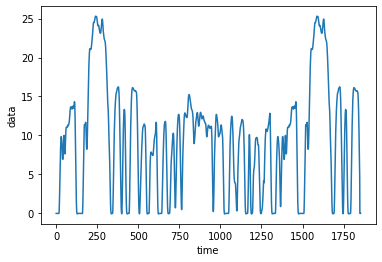

In [17]:
def plot(data):
    x = np.arange(0, len(data), 1)
    y = data
    plt.plot(x, y)
    plt.xlabel('time')
    plt.ylabel('data')
    plt.show()
# 车速
plot(Velocity1.T)

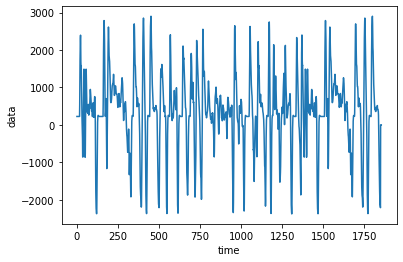

In [18]:
# 转矩
plot(Torque1)

In [19]:
speed_max =  np.max([np.max(Velocity1)])
Torque_max = np.max([np.max(Torque1)])
Torque_min = np.min([np.min(Torque1)])
total_milage = (np.sum(Velocity1)) 
print ( '最大车速:', speed_max, '最大转矩:', Torque_max, '最小转矩:', Torque_min,'总里程:', total_milage)

最大车速: 25.293015274053705 最大转矩: 2901.007585556707 最小转矩: -2378.5321623879136 总里程: 17762.837534146707


In [20]:
s_dim = 3      # 状态
a_dim = 1      # 动作
a_bound = 1
DDPG = DDPG(a_dim, s_dim, a_bound)  # DDPG
var = 2
total_milage = np.sum(Velocity1) / 1000   # 总里程  km
EREV = EREV()             # 增程式电动汽车模型

ValueError: Variable Actor/eval/l1/kernel already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "B:\Anaconda\Anaconda3\envs\TF1.15\lib\site-packages\tensorflow_core\python\framework\ops.py", line 1748, in __init__
    self._traceback = tf_stack.extract_stack()
  File "B:\Anaconda\Anaconda3\envs\TF1.15\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3426, in _create_op_internal
    op_def=op_def)
  File "B:\Anaconda\Anaconda3\envs\TF1.15\lib\site-packages\tensorflow_core\python\framework\ops.py", line 3357, in create_op
    attrs, op_def, compute_device)
  File "B:\Anaconda\Anaconda3\envs\TF1.15\lib\site-packages\tensorflow_core\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "B:\Anaconda\Anaconda3\envs\TF1.15\lib\site-packages\tensorflow_core\python\framework\op_def_library.py", line 794, in _apply_op_helper
    op_def=op_def)


In [ ]:
# 一个循环最终SOC
SOC_final_list=[]
# 一个循环油钱
Total_fuel_RMB1_list=[]
# 一个循环电钱
Total_elec_RMB1_list=[]
# 一个循环花钱
Total_RMB1_list=[]
# 百公里燃油消耗
Total_fuel_100Km_list=[]
# 一个循环奖励
reward1_all_list=[]
# 平均奖励
mean_reward_list=[]
mean_reward = 0 

## 循环

In [12]:
for i in range(MAX_EPISODES): 

    ep_reward = 0                     # 每步奖励
    ep_reward_all = 0                 # 总奖励
    a = 0                             # 动作
    A = 0
    step_episode += 1                 # 步数
    Reward_list = []
    Reward_list_all = []
    # 发动机
    Eng_spd_list = []                 # 发动机转速
    Eng_trq_list = []                 # 发动机转矩
    Eng_pwr_list = []                 # 发动机功率
    Eng_eta_list = []                 # 发动机效率
    Eng_pwr_opt_list = []             # 发动机工作点
    # 发电机
    Gen_spd_list = []                 # 发电机转速
    Gen_trq_list = []                 # 发电机转矩
    Gen_pwr_list = []                 # 发电机功率
    Gen_eta_list = []                 # 发电机效率
    # 驱动电机
    Mot_spd_list = []                 # 驱动电机转速
    Mot_trq_list = []                 # 驱动电机转矩
    Mot_pwr_list = []                 # 驱动电机功率
    Mot_eta_list = []                 # 驱动电机效率
    # 电池
    Batt_pwr_list = []                # 电池输出功率
    inf_batt_list = []
    inf_batt_one_list = []
    # 钱
    fuel = 0;   fuel_list=[];   Total_fuel_RMB = 0;   elec = 0;   elec_list=[];  
    Tota_elec1_RMB = 0; Total_RMB_cost = 0;   RMB_cost_list = [];  
    RMB_cost = 0;   Total_fuel  = 0; 
    # 车辆状态
    SOC = 0.65
    SOC_origin = SOC                  # 初始SOC
    SOC_data = []                     # 每个循环内SOC变化情况
    # 驱动、制动转矩
    T = 0                             # 驱动、制动转矩
    P_req_list = []                   # 轮胎驱动需求功率
    # 车速
    V = Velocity1[0]       # 车速
    T = Torque1[0]
    # 状态空间 v、T、SOC
    s = np.zeros(s_dim)
    s[0] = V        # 车速
    s[1] = (T - Torque_max) / (Torque_max-Torque_min)                   # 将加速度改为驱动和制动转矩   (car_a - (-1.5)) / (1.5- (-1.5))
    s[2] = SOC                        # SOC
    # 驾驶工况循环   1-1219
    for j in range(len(Velocity1) - 1):
        # 动作选取
        action = DDPG.choose_action(s)
        # clip 函数将数组中的元素限制在a_min, a_max之间
        a = np.clip(np.random.laplace(action, var), -1, 1)
        Eng_pwr_opt = (a[0]) * 85000
        # 运行增程式电动汽车模型
        out, RMB_cost, soc = EREV.run(V, T, Eng_pwr_opt, SOC)
        # 发动机
        Eng_spd_list.append(float(out['W_eng']))         # 发动机转速
        Eng_trq_list.append(float(out['T_eng']))         # 发动机转矩
        Eng_pwr_list.append(float(out['P_eng']))         # 发动机功率
        Eng_eta_list.append(float(out['eff_e']))         # 发动机效率
        Eng_pwr_opt_list.append(float(out['P_eng'])) # 发动机工作点
        # 发电机
        Gen_spd_list.append(float(out['W_gen']))         # 发电机转速
        Gen_trq_list.append(float(out['T_gen']))         # 发电机转矩
        Gen_pwr_list.append(float(out['P_eng']))         # 发电机功率
        Gen_eta_list.append(float(out['eff_g']))         # 发电机效率
        # 驱动电机
        Mot_spd_list.append(float(out['W_mot']))         # 驱动电机转速
        Mot_trq_list.append(float(out['T_mot']))         # 驱动电机转矩
        Mot_pwr_list.append(float(out['P_mot']))         # 驱动电机功率
        Mot_eta_list.append(float(out['eff_m']))         # 驱动电机效率
        # 电池
        Batt_pwr_list.append(float(out['P_batt']))       # 电池功率
        # 输出状态列表
        P_req_list.append(float(out['P_axle']))             # 轮胎驱动需求功率

        # 电池SOC
        SOC_new = float(soc)                        # 电池SOC
        SOC_data.append(SOC_new)                           # 一个循环SOC变化情况
        cost = float(RMB_cost)                                 # 增程器燃油消耗
        V = Velocity1[j + 1]                    # 车速
        T = Torque1[j+1]
        # 车辆状态空间  V、T、SOC
        s_ = np.zeros(s_dim)
        s_[0] = V  # 车速
        s_[1] = (T - Torque_max) / (Torque_max-Torque_min)   # 加速度改为转矩 (car_a - (-1.5)) / (1.5- (-1.5))
        s_[2] = SOC_new        # SOC
        # 奖励 = RMB_cost 
        r = RMB_cost               
        ep_reward += r        
        Reward_list.append(r)  
        # SOC (0.45～0.85) 奖励 = -(α|ΔSOC|^2 + βfuel)
        r = (-RMB_cost - 3 * (0.55 - SOC)**2)
        # DDPG状态存储
        DDPG.store_transition(s, a, r, s_)
        
        if total_step > MEMORY_CAPACITY:
            var *= 0.99993
            DDPG.learn()
        # 状态更新
        s = s_                       # 状态更新
        SOC = SOC_new                # SOC更新
        ep_reward_all += r           # 奖励和     -(α|ΔSOC|^2 + βfuel)
        Reward_list_all.append(r)    # 奖励列表   -(α|ΔSOC|^2 + βfuel)
        total_step += 1              # 总步数+1
        cost_Engine = (ep_reward / 0.725 / 1000)    # 增程器燃油总消耗   L cost_Engine = - (cost / 0.725 / 1000)
        cost_all = (ep_reward_all / 0.725 / 1000)   # 奖励和等效燃油消耗 L (-(α|ΔSOC|^2 + βfuel)) / 0.725 / 1000)
        # 完成每次循环工况输出
        if j == (len(Velocity1) - 2):
            SOC_final_list.append(SOC)                          # 每个循环最终SOC值
            mean_reward = ep_reward_all / Velocity1.shape[1]  # 每个循环的平均奖励
            mean_reward_list.append(mean_reward)                # 每个循环的平均奖励列表
            # 燃油总消耗(cost_Engine) = 每次循环消耗的电量转变为燃油 + 增程器燃油总消耗
            cost_Engine += (SOC < SOC_origin) * (SOC_origin - SOC) * (350 * 75) * 3600 / 43070 / 0.725 / 1000
            cost_Engine_list.append(cost_Engine)
            # 百公里燃油消耗(cost_Engine_100Km_list) = 燃油总消耗(cost_Engine) / 总行驶里程(total_milage)
            cost_Engine_100Km_list.append(cost_Engine * (100 / total_milage))
            # 奖励和等效燃油消耗(cost_all) =  (-(α|ΔSOC|^2 + βfuel)) / 0.725 / 1000) + 每次循环消耗的电量转变为燃油
            cost_all += (SOC < SOC_origin) * (SOC_origin - SOC) * (350 * 75) * 3600 / 43070 / 0.725 / 1000
            cost_all_list.append(cost_all)
            print('循环次数:', i, '燃油消耗: %.3f g' % ep_reward, '燃油消耗: %.3f L' % cost_Engine, '百公里燃油消耗: %.3f L/100km' % (cost_Engine * (100 / total_milage)), '最终SOC: %.3f' % SOC_new, ' Explore: %.2f' % var)

    mean_reward_all += mean_reward   
   
    DDPG.savemodel()

IndexError: tuple index out of range

## 结果处理

In [24]:
mean_discrepancy_list = list(map(lambda x, y: y - x, list_even, list_odd))

In [56]:
def plot(data):
    x = np.arange(0, len(data), 1)
    y = data
    plt.plot(x, y)
    plt.xlabel('time')
    plt.ylabel('data')
    plt.show()

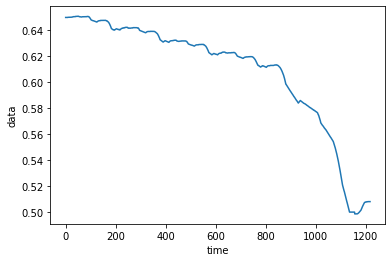

In [57]:
plot(SOC_data) # SOC变化值

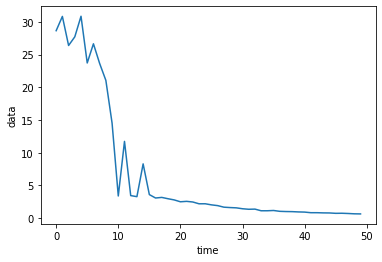

In [58]:
plot(cost_all_list)

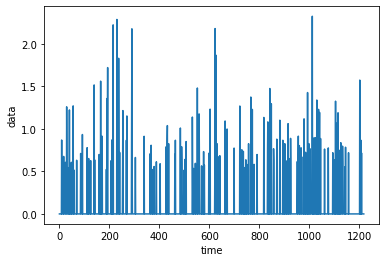

In [59]:
plot(Reward_list)  # 燃油消耗列表 g

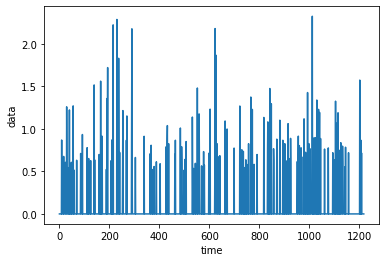

In [64]:
plot(Reward_list_all) # 奖励列表   -(α|ΔSOC|^2 + βfuel)

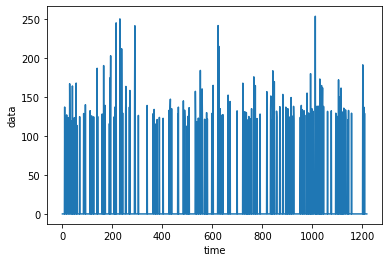

In [65]:
plot(Eng_spd_list)# 发动机转速

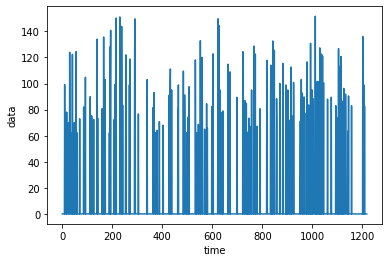

In [66]:
plot(Eng_trq_list)# 发动机转矩

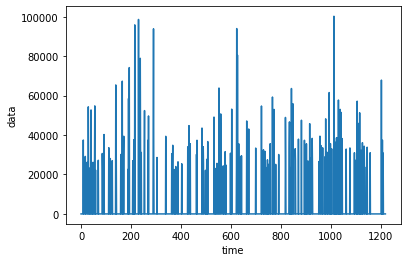

In [76]:
plot(Eng_pwr_list)# 发动机功率

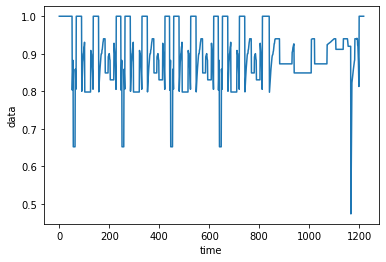

In [78]:
plot(Eng_eta_list)# 发电机效率

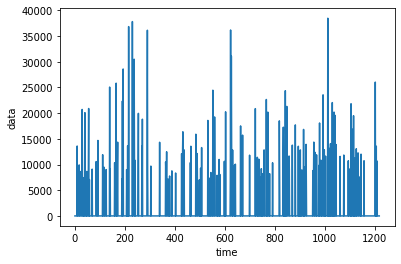

In [79]:
plot(Eng_pwr_opt_list)# 发动机工作点

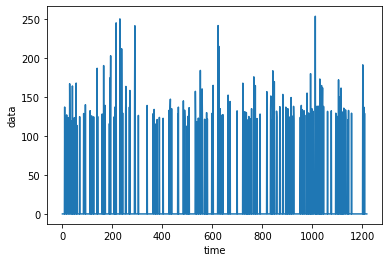

In [80]:
plot(Gen_spd_list)# 发电机转速

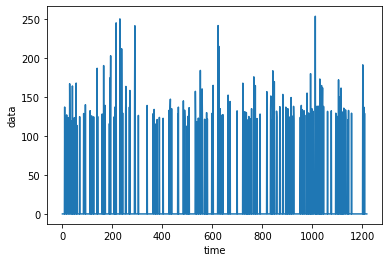

In [81]:
plot(Gen_spd_list)# 发电机转矩

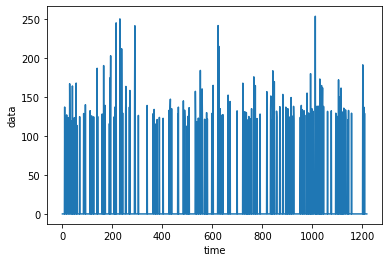

In [82]:
plot(Gen_spd_list)# 发电机功率

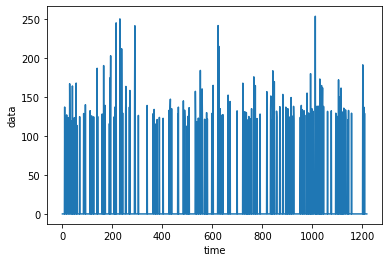

In [83]:
plot(Gen_spd_list)# 发电机效率

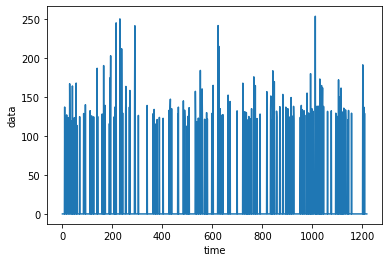

In [84]:
plot(Gen_spd_list)# 驱动电机转速

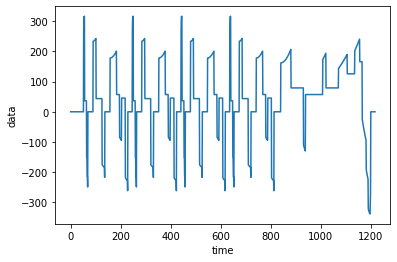

In [85]:
plot(Mot_trq_list)# 驱动电机转矩

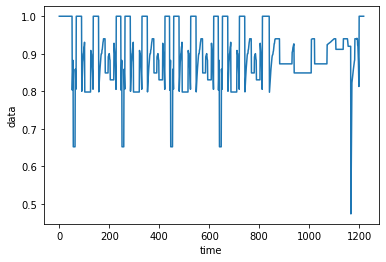

In [87]:
plot(Mot_eta_list )  # 驱动电机效率

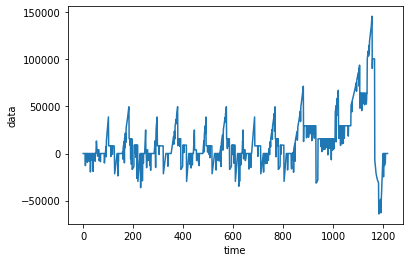

In [71]:
plot(Batt_pwr_list )  # 电池输出功率

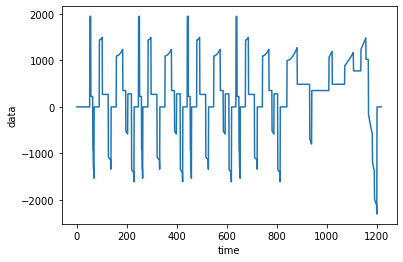

In [72]:
plot(T_list )             # 轮胎驱动转矩

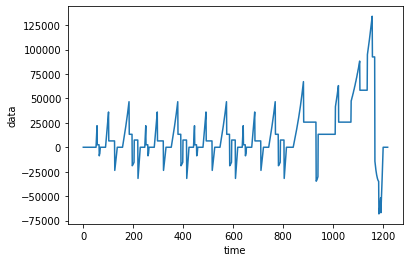

In [73]:
plot(P_req_list )       # 轮胎驱动需求功率

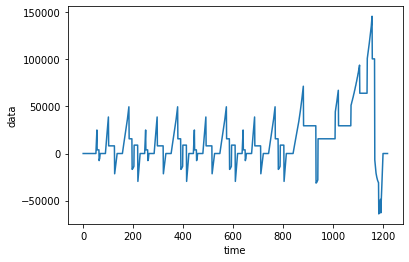

In [74]:
plot(P_out_list )     # 电池+增程器=输出功率

In [75]:
plot(car_a_list )      # 加速度

NameError: name 'car_a_list' is not defined